In [1]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_survival_data.csv to preprocessed_survival_data.csv


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv("/content/preprocessed_survival_data.csv")
df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,52,White,Married (including common law),T1,N1,IIA,Well differentiated; Grade I,Regional,10,Positive,Positive,19,1,107,Alive
4019,53,White,Married (including common law),T1,N2,IIIA,Poorly differentiated; Grade III,Regional,9,Negative,Negative,13,5,107,Alive
4020,53,White,Divorced,T1,N1,IIA,Moderately differentiated; Grade II,Regional,9,Negative,Negative,4,2,107,Alive
4021,60,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T1,N1,IIA,Moderately differentiated; Grade II,Regional,9,Positive,Positive,14,2,107,Alive


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023 entries, 0 to 4022
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4023 non-null   int64 
 1   Race                    4023 non-null   object
 2   Marital Status          4023 non-null   object
 3   T Stage                 4023 non-null   object
 4   N Stage                 4023 non-null   object
 5   6th Stage               4023 non-null   object
 6   Grade                   4023 non-null   object
 7   A Stage                 4023 non-null   object
 8   Tumor Size              4023 non-null   int64 
 9   Estrogen Status         4023 non-null   object
 10  Progesterone Status     4023 non-null   object
 11  Regional Node Examined  4023 non-null   int64 
 12  Reginol Node Positive   4023 non-null   int64 
 13  Survival Months         4023 non-null   int64 
 14  Status                  4023 non-null   object
dtypes: i

## **Feature Enginnering**

In [43]:
df_encoded = df.copy()

# 1. Encode 'Status' (Target Variable)
df_encoded["Status"] = df_encoded['Status'].map({'Alive': 0, 'Dead': 1})

# 2. Age Grouping
age_bins = [0, 40, 50, 60, 70, 100]
age_labels = ['<40', '40-49', '50-59', '60-69', '70+']
df_encoded['Age_Group'] = pd.cut(df_encoded['Age'], bins=age_bins, labels=age_labels)
df_encoded.drop(columns='Age', inplace=True)

# 3. One-hot encode nominal categorical variables (drop_first avoids multicollinearity)
categorical_cols = ['Race', 'Marital Status', 'Age_Group']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# 4. Ordinal encoding for ordered features
from sklearn.preprocessing import OrdinalEncoder

ordinal_cols = ['6th Stage', 'N Stage', 'A Stage', 'Grade', 'T Stage']
ordinal_orders = [
    ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC'],
    ['N1', 'N2', 'N3'],
    ['Regional', 'Distant'],
    [
        'Well differentiated; Grade I',
        'Moderately differentiated; Grade II',
        'Poorly differentiated; Grade III',
        'Undifferentiated; anaplastic; Grade IV'
    ],
    ['T1', 'T2', 'T3', 'T4']
]

ord_enc = OrdinalEncoder(categories=ordinal_orders)
df_encoded[ordinal_cols] = ord_enc.fit_transform(df_encoded[ordinal_cols])

# 5. Log-transform Tumor Size (add small value if needed to avoid log(0))
df_encoded['Tumor_Size_Log'] = np.log1p(df_encoded['Tumor Size'])
df_encoded.drop(columns='Tumor Size', inplace=True)

# 6. Map Hormone Receptor Status
status_map = {'Positive': 1, 'Negative': 0}
df_encoded['Estrogen Status'] = df_encoded['Estrogen Status'].map(status_map)
df_encoded['Progesterone Status'] = df_encoded['Progesterone Status'].map(status_map)

# 7. Node Positive Ratio (avoid divide-by-zero by replacing 0s with NaN, then fill with 0)
df_encoded['Node_Positive_Ratio'] = df_encoded['Reginol Node Positive'] / df_encoded['Regional Node Examined'].replace(0, np.nan)
df_encoded['Node_Positive_Ratio'] = df_encoded['Node_Positive_Ratio'].fillna(0)
df_encoded.drop(columns=['Reginol Node Positive', 'Regional Node Examined'], inplace=True)


In [10]:
!pip install scikit-survival --no-binary scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.1 MB/s eta 0:00:00
  Created wheel for scikit-survival: filename=scikit_survival-0.24.1-cp311-cp311-linux_x86_64.whl size=3368625 sha256=3f48246977f1f3ad5c08ac6e02dc4617024989833679d838a695e7c3879acbc3
  Stored in directory: /root/.cache/pip/wheels/0e/d3/b8/11c31ce4a697762c345b83b05ef82674d35afe0d759b045b6e
Successfully built scikit-survival
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


Original features: 19, After VarianceThreshold: 18


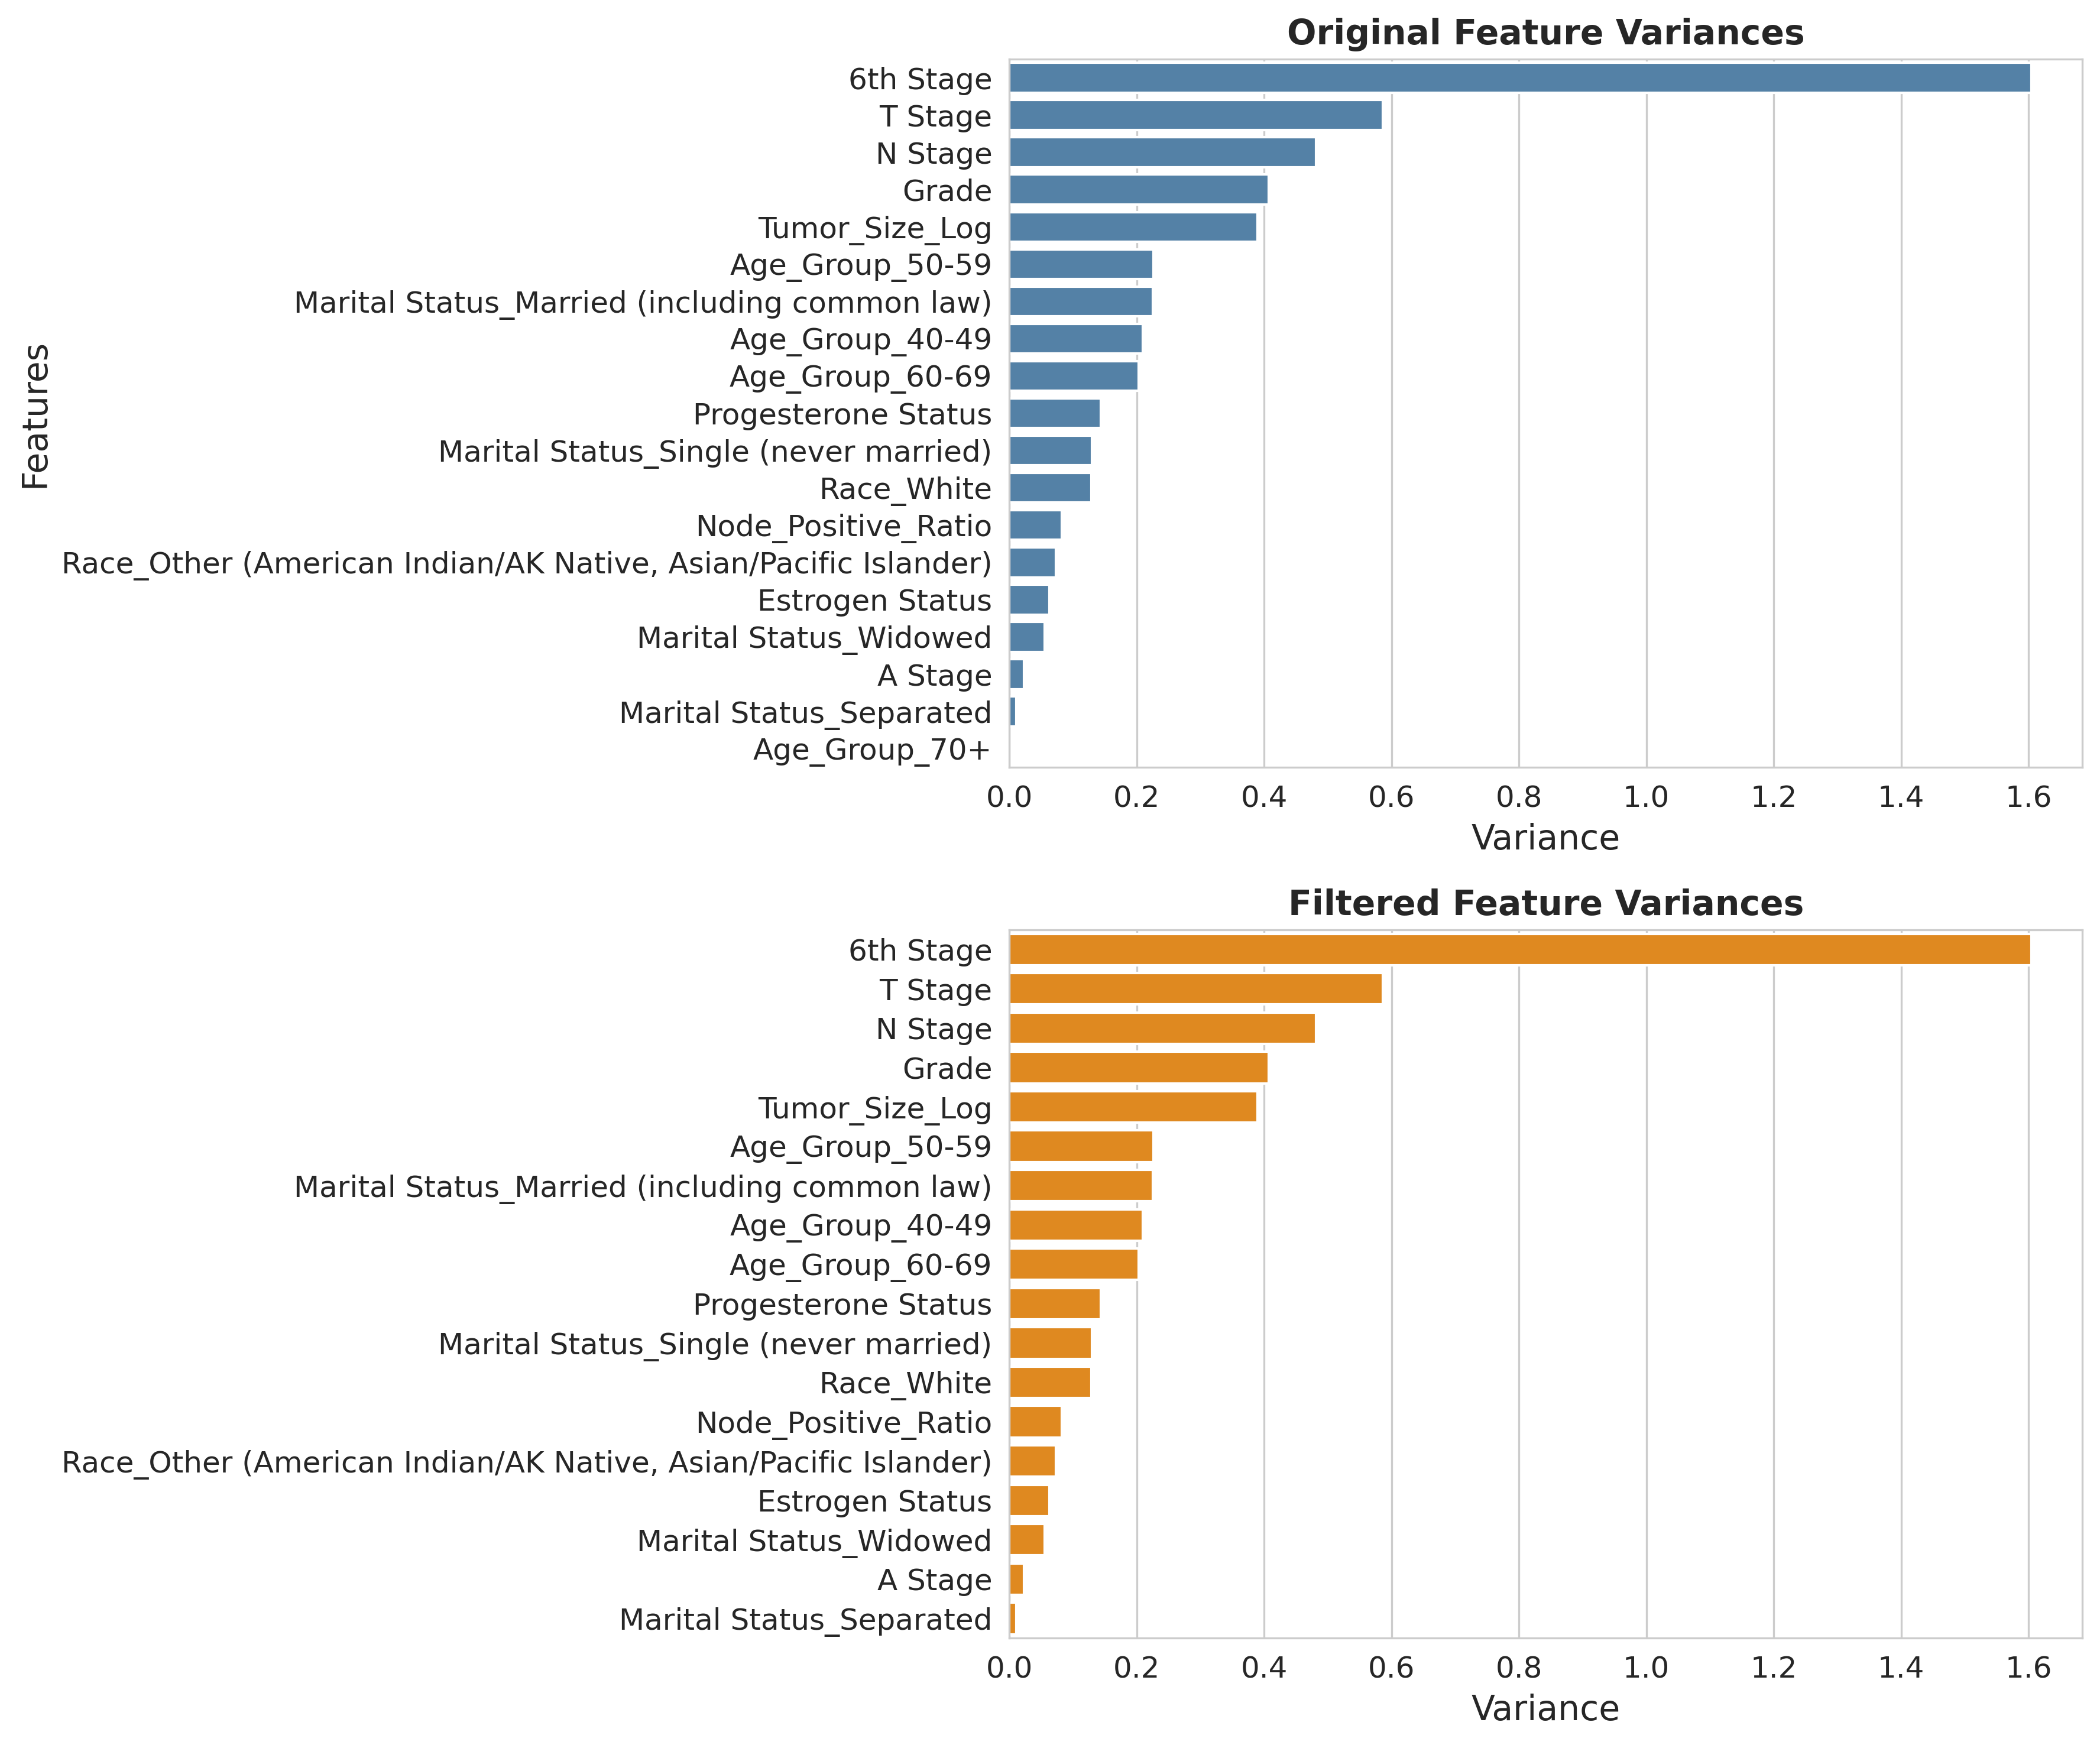

In [44]:
# === IMPORTS ===
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import (
    concordance_index_censored,
    brier_score,
    integrated_brier_score,
    cumulative_dynamic_auc
)
import shap
import matplotlib.pyplot as plt
import joblib

# === 1) Prepare data ===

X = df_encoded.drop(columns=["Survival Months", "Status"])
y_struct = np.array(
    [(bool(event), time) for event, time in zip(df_encoded["Status"], df_encoded["Survival Months"])],
    dtype=[("event", "bool"), ("time", "float64")]
)

# === 2) Feature selection ===
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support()]
X_filtered = pd.DataFrame(X_filtered, columns=selected_columns)
print(f"Original features: {X.shape[1]}, After VarianceThreshold: {X_filtered.shape[1]}")

# Calculate variances for original and filtered features
variances_original = X.var()
variances_filtered = X_filtered.var()

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column

variances_original_sorted = variances_original.sort_values(ascending=False)
variances_filtered_sorted = variances_filtered.sort_values(ascending=False)

sns.barplot(x=variances_original_sorted.values, y=variances_original_sorted.index, ax=axs[0], color='steelblue')
axs[0].set_title('Original Feature Variances', fontsize=14, weight='bold')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Features')

sns.barplot(x=variances_filtered_sorted.values, y=variances_filtered_sorted.index, ax=axs[1], color='darkorange')
axs[1].set_title('Filtered Feature Variances', fontsize=14, weight='bold')
axs[1].set_xlabel('Variance')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()



In [45]:
# === 3) Train/Val/Test split ===
stratify_status = df_encoded["Status"]
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_filtered, y_struct, test_size=0.2, random_state=42, stratify=stratify_status
)
stratify_train_val = stratify_status.loc[X_train_val.index]
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=stratify_train_val
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (2413, 18), Val: (805, 18), Test: (805, 18)


In [25]:
# === 4) RSF model training ===
rsf_model = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf_model.fit(X_train, y_train)

# === 5) Basic evaluation: Concordance Index ===
val_cindex = concordance_index_censored(y_val['event'], y_val['time'], rsf_model.predict(X_val))[0]
test_cindex = concordance_index_censored(y_test['event'], y_test['time'], rsf_model.predict(X_test))[0]
print(f"Concordance Index (Val): {val_cindex:.4f}")
print(f"Concordance Index (Test): {test_cindex:.4f}\n")

# === 6) Integrated Brier Score (IBS) + Time-dependent AUC ===
median_time = np.percentile(y_struct["time"], 50)
unique_times = np.percentile(y_struct["time"], np.linspace(5, 95, 20))

# Validation set survival probabilities
val_surv_funcs = rsf_model.predict_survival_function(X_val)
val_surv_probs = np.vstack([fn(unique_times) for fn in val_surv_funcs])

ibs_val = integrated_brier_score(y_train, y_val, val_surv_probs, unique_times)
print(f"Integrated Brier Score (Val): {ibs_val:.4f}")

auc_vals, mean_auc_val = cumulative_dynamic_auc(y_train, y_val, rsf_model.predict(X_val), unique_times)
print(f"Time-dependent AUC (Val) at median time: {auc_vals[len(auc_vals)//2]:.4f}")
print(f"Mean time-dependent AUC (Val): {mean_auc_val:.4f}")

# Brier score at median time for Validation
idx_median = np.argmin(np.abs(unique_times - median_time))
val_brier_median_probs = val_surv_probs[:, idx_median].reshape(-1, 1)
val_brier_median = brier_score(y_train, y_val, val_brier_median_probs, np.array([median_time]))[1][0]
print(f"Brier Score @ median time (Val): {val_brier_median:.4f}\n")

# Test set survival probabilities
test_surv_funcs = rsf_model.predict_survival_function(X_test)
test_surv_probs = np.vstack([fn(unique_times) for fn in test_surv_funcs])

ibs_test = integrated_brier_score(y_train_val, y_test, test_surv_probs, unique_times)
print(f"Integrated Brier Score (Test): {ibs_test:.4f}")

aucs_test, mean_auc_test = cumulative_dynamic_auc(y_train_val, y_test, rsf_model.predict(X_test), unique_times)
print(f"Mean time-dependent AUC (Test): {mean_auc_test:.4f}")

# Brier score at median time for Test
test_brier_median_probs = test_surv_probs[:, idx_median].reshape(-1, 1)
test_brier_median = brier_score(y_train_val, y_test, test_brier_median_probs, np.array([median_time]))[1][0]
print(f"Brier Score @ median time (Test): {test_brier_median:.4f}\n")

# === 7) 5-fold Cross-validation ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_cindex, cv_ibs, cv_brier_median, cv_mean_auc = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_filtered)):
    X_train_cv, X_test_cv = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train_cv, y_test_cv = y_struct[train_idx], y_struct[test_idx]

    model_cv = RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=20,
        min_samples_leaf=15,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )
    model_cv.fit(X_train_cv, y_train_cv)

    pred_cv = model_cv.predict(X_test_cv)
    cindex = concordance_index_censored(y_test_cv['event'], y_test_cv['time'], pred_cv)[0]

    surv_funcs_cv = model_cv.predict_survival_function(X_test_cv)
    surv_probs_cv = np.vstack([fn(unique_times) for fn in surv_funcs_cv])

    ibs = integrated_brier_score(y_train_cv, y_test_cv, surv_probs_cv, unique_times)

    # Brier score at median time for CV fold
    surv_probs_median = surv_probs_cv[:, idx_median].reshape(-1, 1)
    brier_median = brier_score(y_train_cv, y_test_cv, surv_probs_median, np.array([median_time]))[1][0]

    aucs, mean_auc = cumulative_dynamic_auc(y_train_cv, y_test_cv, pred_cv, unique_times)

    cv_cindex.append(cindex)
    cv_ibs.append(ibs)
    cv_brier_median.append(brier_median)
    cv_mean_auc.append(mean_auc)

    print(f"Fold {fold+1} - C-index: {cindex:.4f}, IBS: {ibs:.4f}, Brier@Median: {brier_median:.4f}, Mean AUC: {mean_auc:.4f}")

print("\n=== Cross-Validation Summary ===")
print(f"Mean C-index: {np.mean(cv_cindex):.4f} ± {np.std(cv_cindex):.4f}")
print(f"Mean IBS: {np.mean(cv_ibs):.4f} ± {np.std(cv_ibs):.4f}")
print(f"Mean Brier Score @ median time: {np.mean(cv_brier_median):.4f} ± {np.std(cv_brier_median):.4f}")
print(f"Mean Time-dependent AUC: {np.mean(cv_mean_auc):.4f} ± {np.std(cv_mean_auc):.4f}")

# === 8) Save CV results ===
results_df = pd.DataFrame({
    "fold": list(range(1, 6)),
    "cindex": np.round(cv_cindex, 4),
    "ibs": np.round(cv_ibs, 4),
    "brier_median": np.round(cv_brier_median, 4),
    "mean_auc": np.round(cv_mean_auc, 4)
})


Concordance Index (Val): 0.7565
Concordance Index (Test): 0.7204

Integrated Brier Score (Val): 0.0957
Time-dependent AUC (Val) at median time: 0.7598
Mean time-dependent AUC (Val): 0.7644
Brier Score @ median time (Val): 0.1093

Integrated Brier Score (Test): 0.0991
Mean time-dependent AUC (Test): 0.7343
Brier Score @ median time (Test): 0.1085

Fold 1 - C-index: 0.7201, IBS: 0.1074, Brier@Median: 0.1218, Mean AUC: 0.7424
Fold 2 - C-index: 0.7180, IBS: 0.0997, Brier@Median: 0.1154, Mean AUC: 0.7277
Fold 3 - C-index: 0.7516, IBS: 0.0839, Brier@Median: 0.0916, Mean AUC: 0.7741
Fold 4 - C-index: 0.7322, IBS: 0.0995, Brier@Median: 0.1128, Mean AUC: 0.7559
Fold 5 - C-index: 0.7101, IBS: 0.0939, Brier@Median: 0.1063, Mean AUC: 0.7279

=== Cross-Validation Summary ===
Mean C-index: 0.7264 ± 0.0145
Mean IBS: 0.0969 ± 0.0078
Mean Brier Score @ median time: 0.1096 ± 0.0103
Mean Time-dependent AUC: 0.7456 ± 0.0177


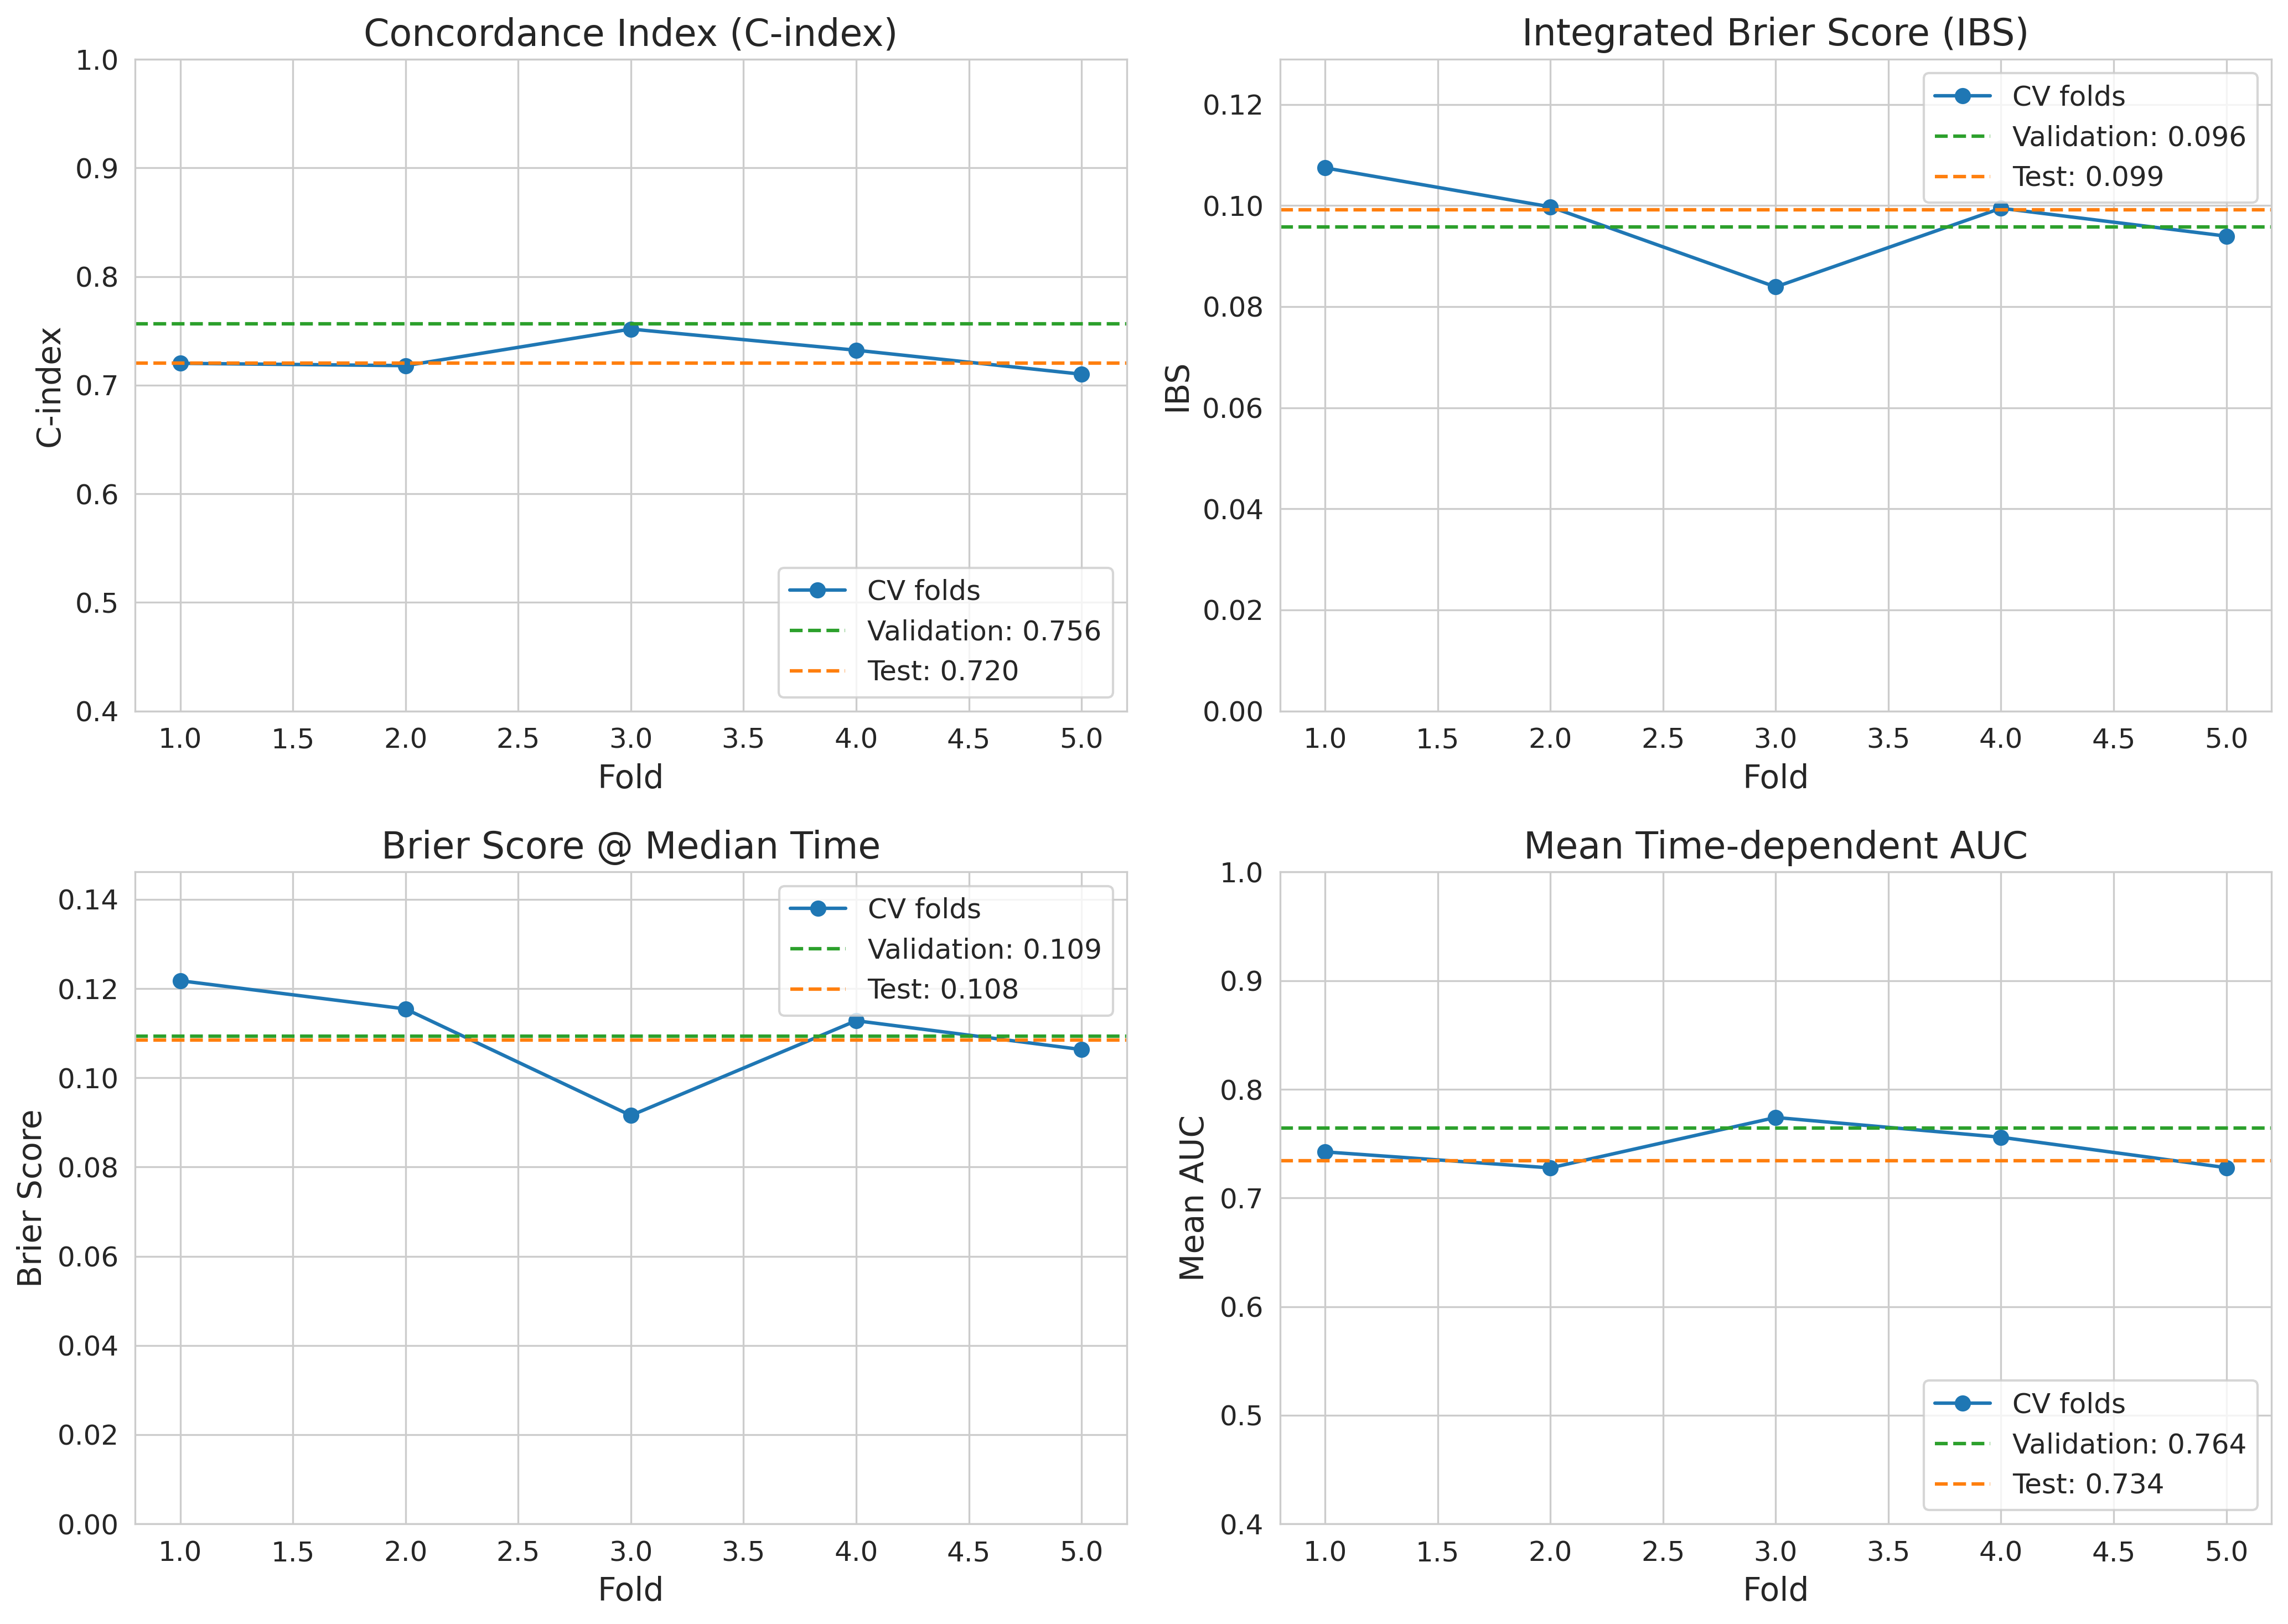

In [29]:
# --- Journal style ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300  # High-res
})

# Folds
folds = list(range(1, len(cv_cindex)+1))

# === 4-panel figure ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === 1) C-index ===
axes[0, 0].plot(folds, cv_cindex, marker='o', linestyle='-', color='#1f77b4', label='CV folds')
axes[0, 0].axhline(y=val_cindex, color='#2ca02c', linestyle='--', label=f'Validation: {val_cindex:.3f}')
axes[0, 0].axhline(y=test_cindex, color='#ff7f0e', linestyle='--', label=f'Test: {test_cindex:.3f}')
axes[0, 0].set_title("Concordance Index (C-index)")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("C-index")
axes[0, 0].set_ylim(0.4, 1)
axes[0, 0].legend(loc='lower right')

# === 2) Integrated Brier Score (IBS) ===
axes[0, 1].plot(folds, cv_ibs, marker='o', linestyle='-', color='#1f77b4', label='CV folds')
axes[0, 1].axhline(y=ibs_val, color='#2ca02c', linestyle='--', label=f'Validation: {ibs_val:.3f}')
axes[0, 1].axhline(y=ibs_test, color='#ff7f0e', linestyle='--', label=f'Test: {ibs_test:.3f}')
axes[0, 1].set_title("Integrated Brier Score (IBS)")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("IBS")
axes[0, 1].set_ylim(0, max(max(cv_ibs), ibs_val, ibs_test) * 1.2)
axes[0, 1].legend(loc='upper right')

# === 3) Brier Score at Median ===
axes[1, 0].plot(folds, cv_brier_median, marker='o', linestyle='-', color='#1f77b4', label='CV folds')
axes[1, 0].axhline(y=val_brier_median, color='#2ca02c', linestyle='--', label=f'Validation: {val_brier_median:.3f}')
axes[1, 0].axhline(y=test_brier_median, color='#ff7f0e', linestyle='--', label=f'Test: {test_brier_median:.3f}')
axes[1, 0].set_title("Brier Score @ Median Time")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("Brier Score")
axes[1, 0].set_ylim(0, max(max(cv_brier_median), val_brier_median, test_brier_median) * 1.2)
axes[1, 0].legend(loc='upper right')

# === 4) Mean Time-dependent AUC ===
axes[1, 1].plot(folds, cv_mean_auc, marker='o', linestyle='-', color='#1f77b4', label='CV folds')
axes[1, 1].axhline(y=mean_auc_val, color='#2ca02c', linestyle='--', label=f'Validation: {mean_auc_val:.3f}')
axes[1, 1].axhline(y=mean_auc_test, color='#ff7f0e', linestyle='--', label=f'Test: {mean_auc_test:.3f}')
axes[1, 1].set_title("Mean Time-dependent AUC")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Mean AUC")
axes[1, 1].set_ylim(0.4, 1)
axes[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.savefig("CV_Val_Test_Metrics.png", dpi=300, bbox_inches='tight')
plt.show()


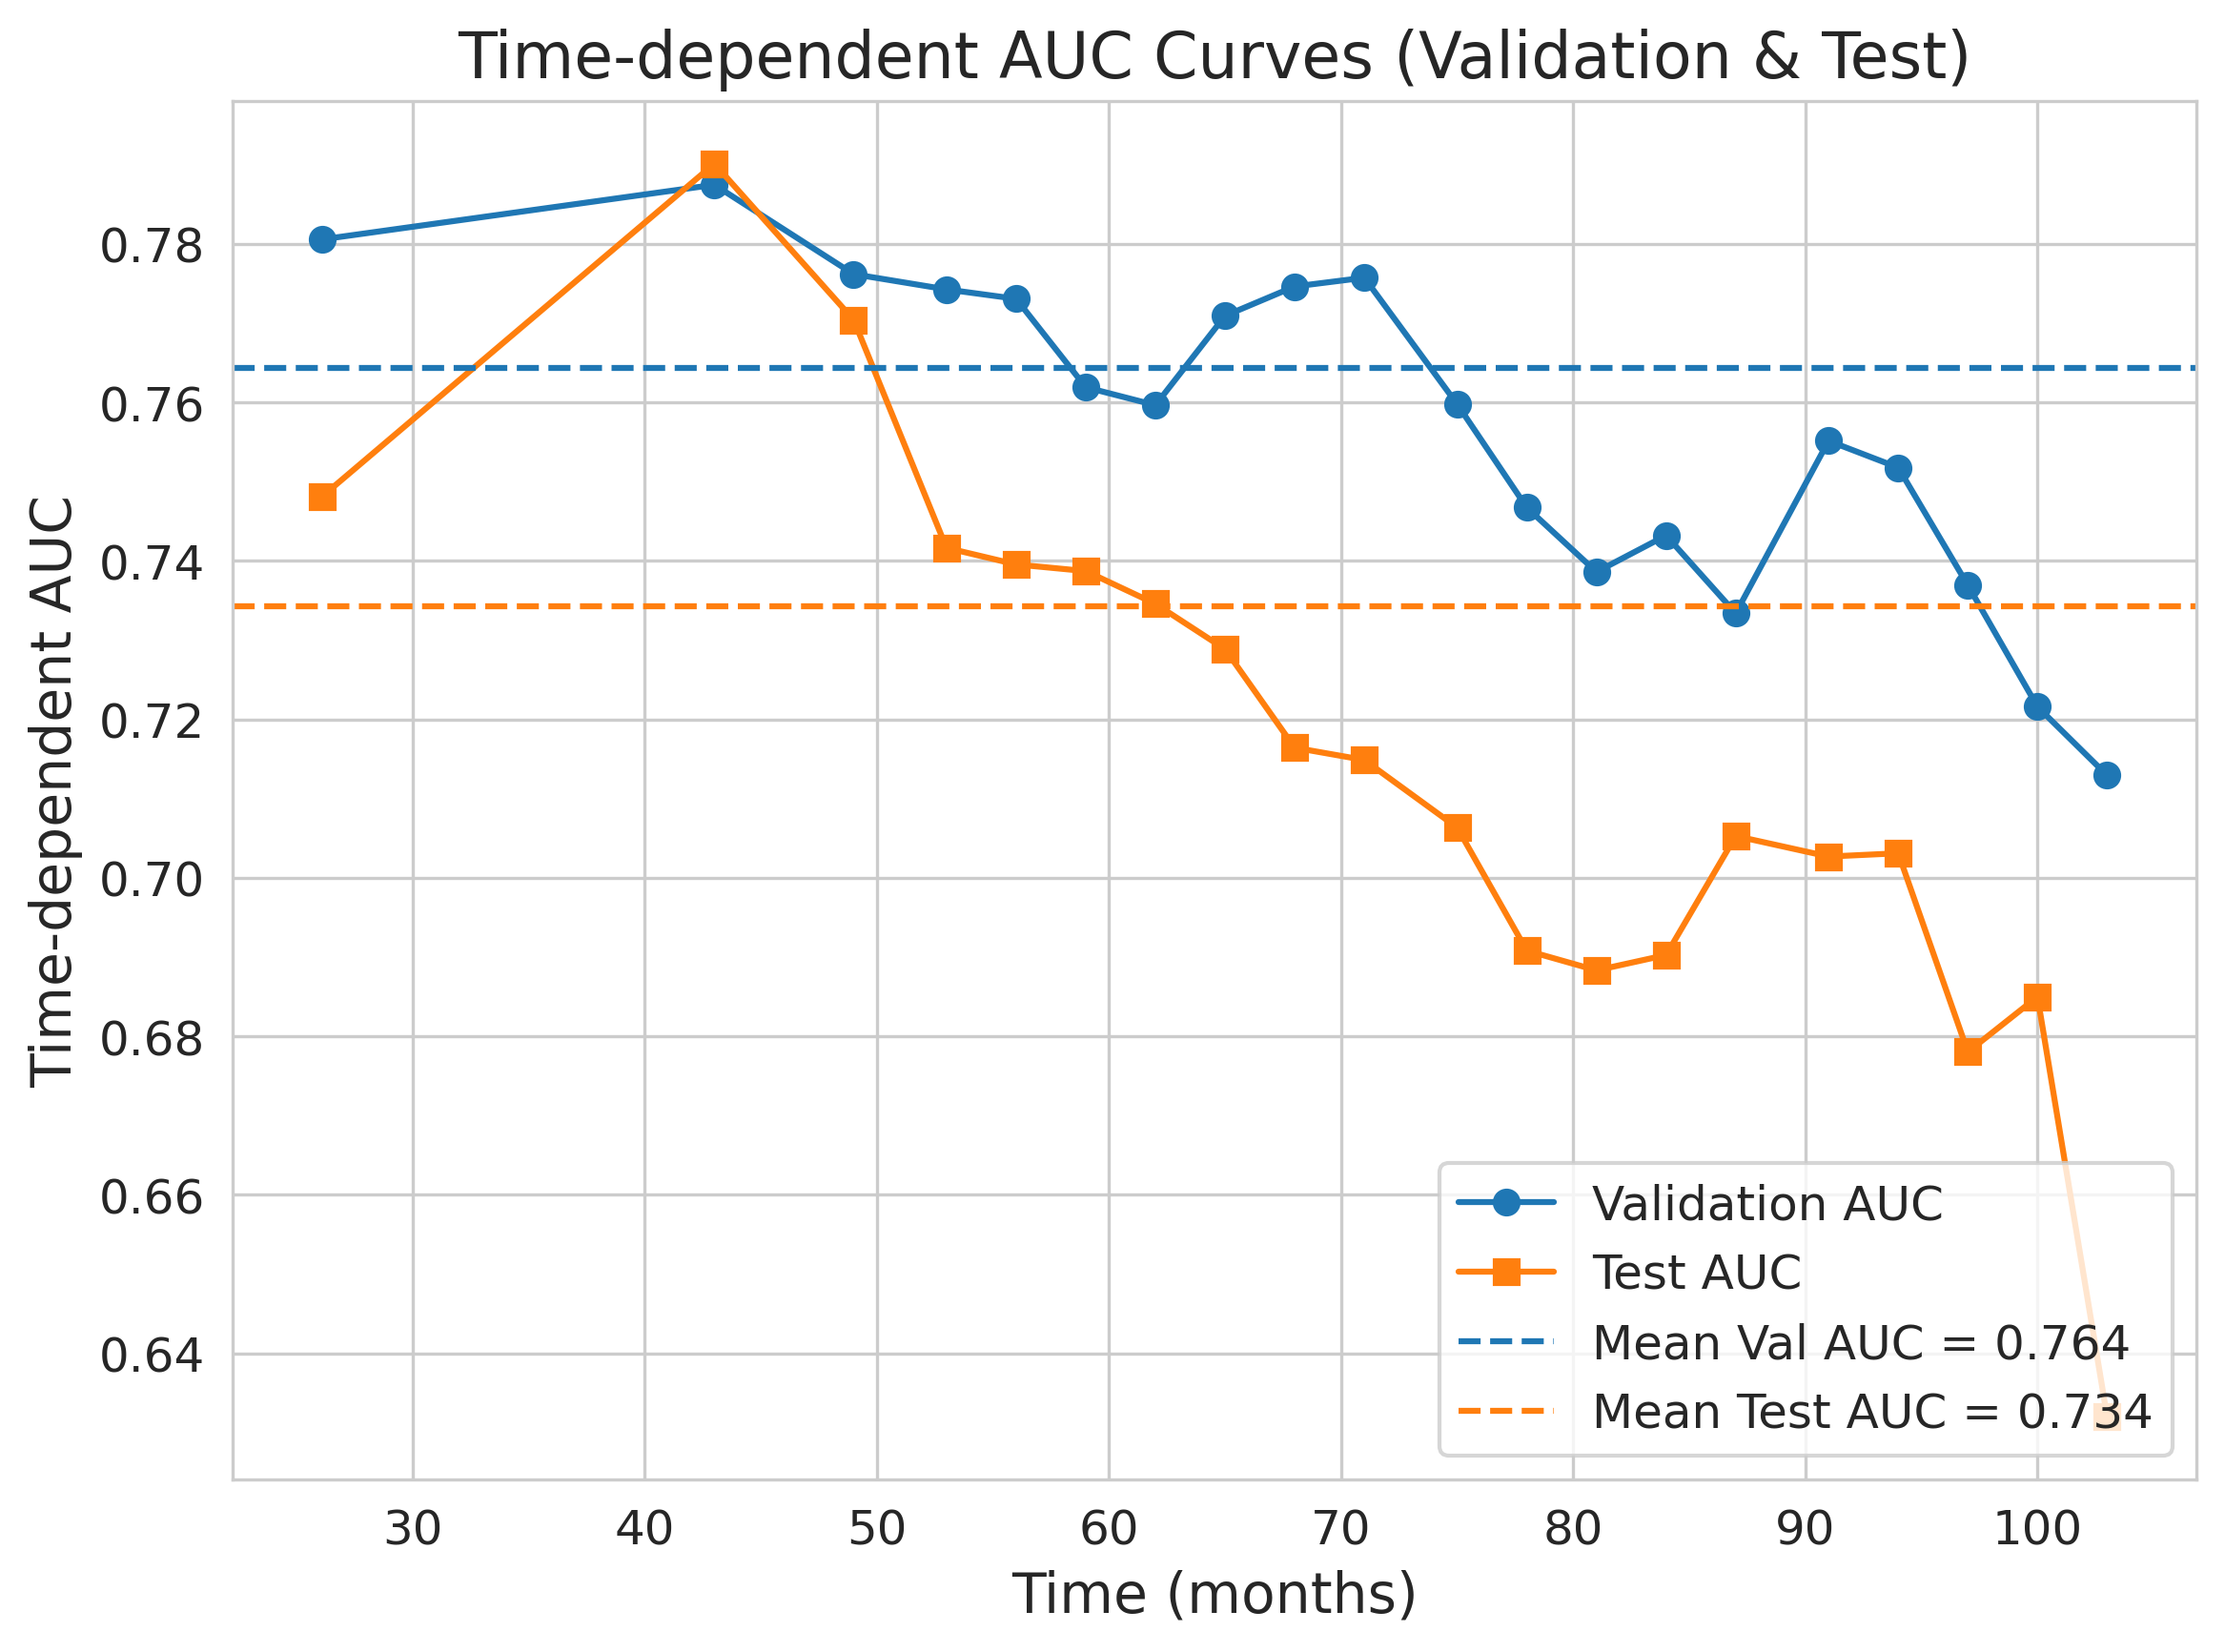

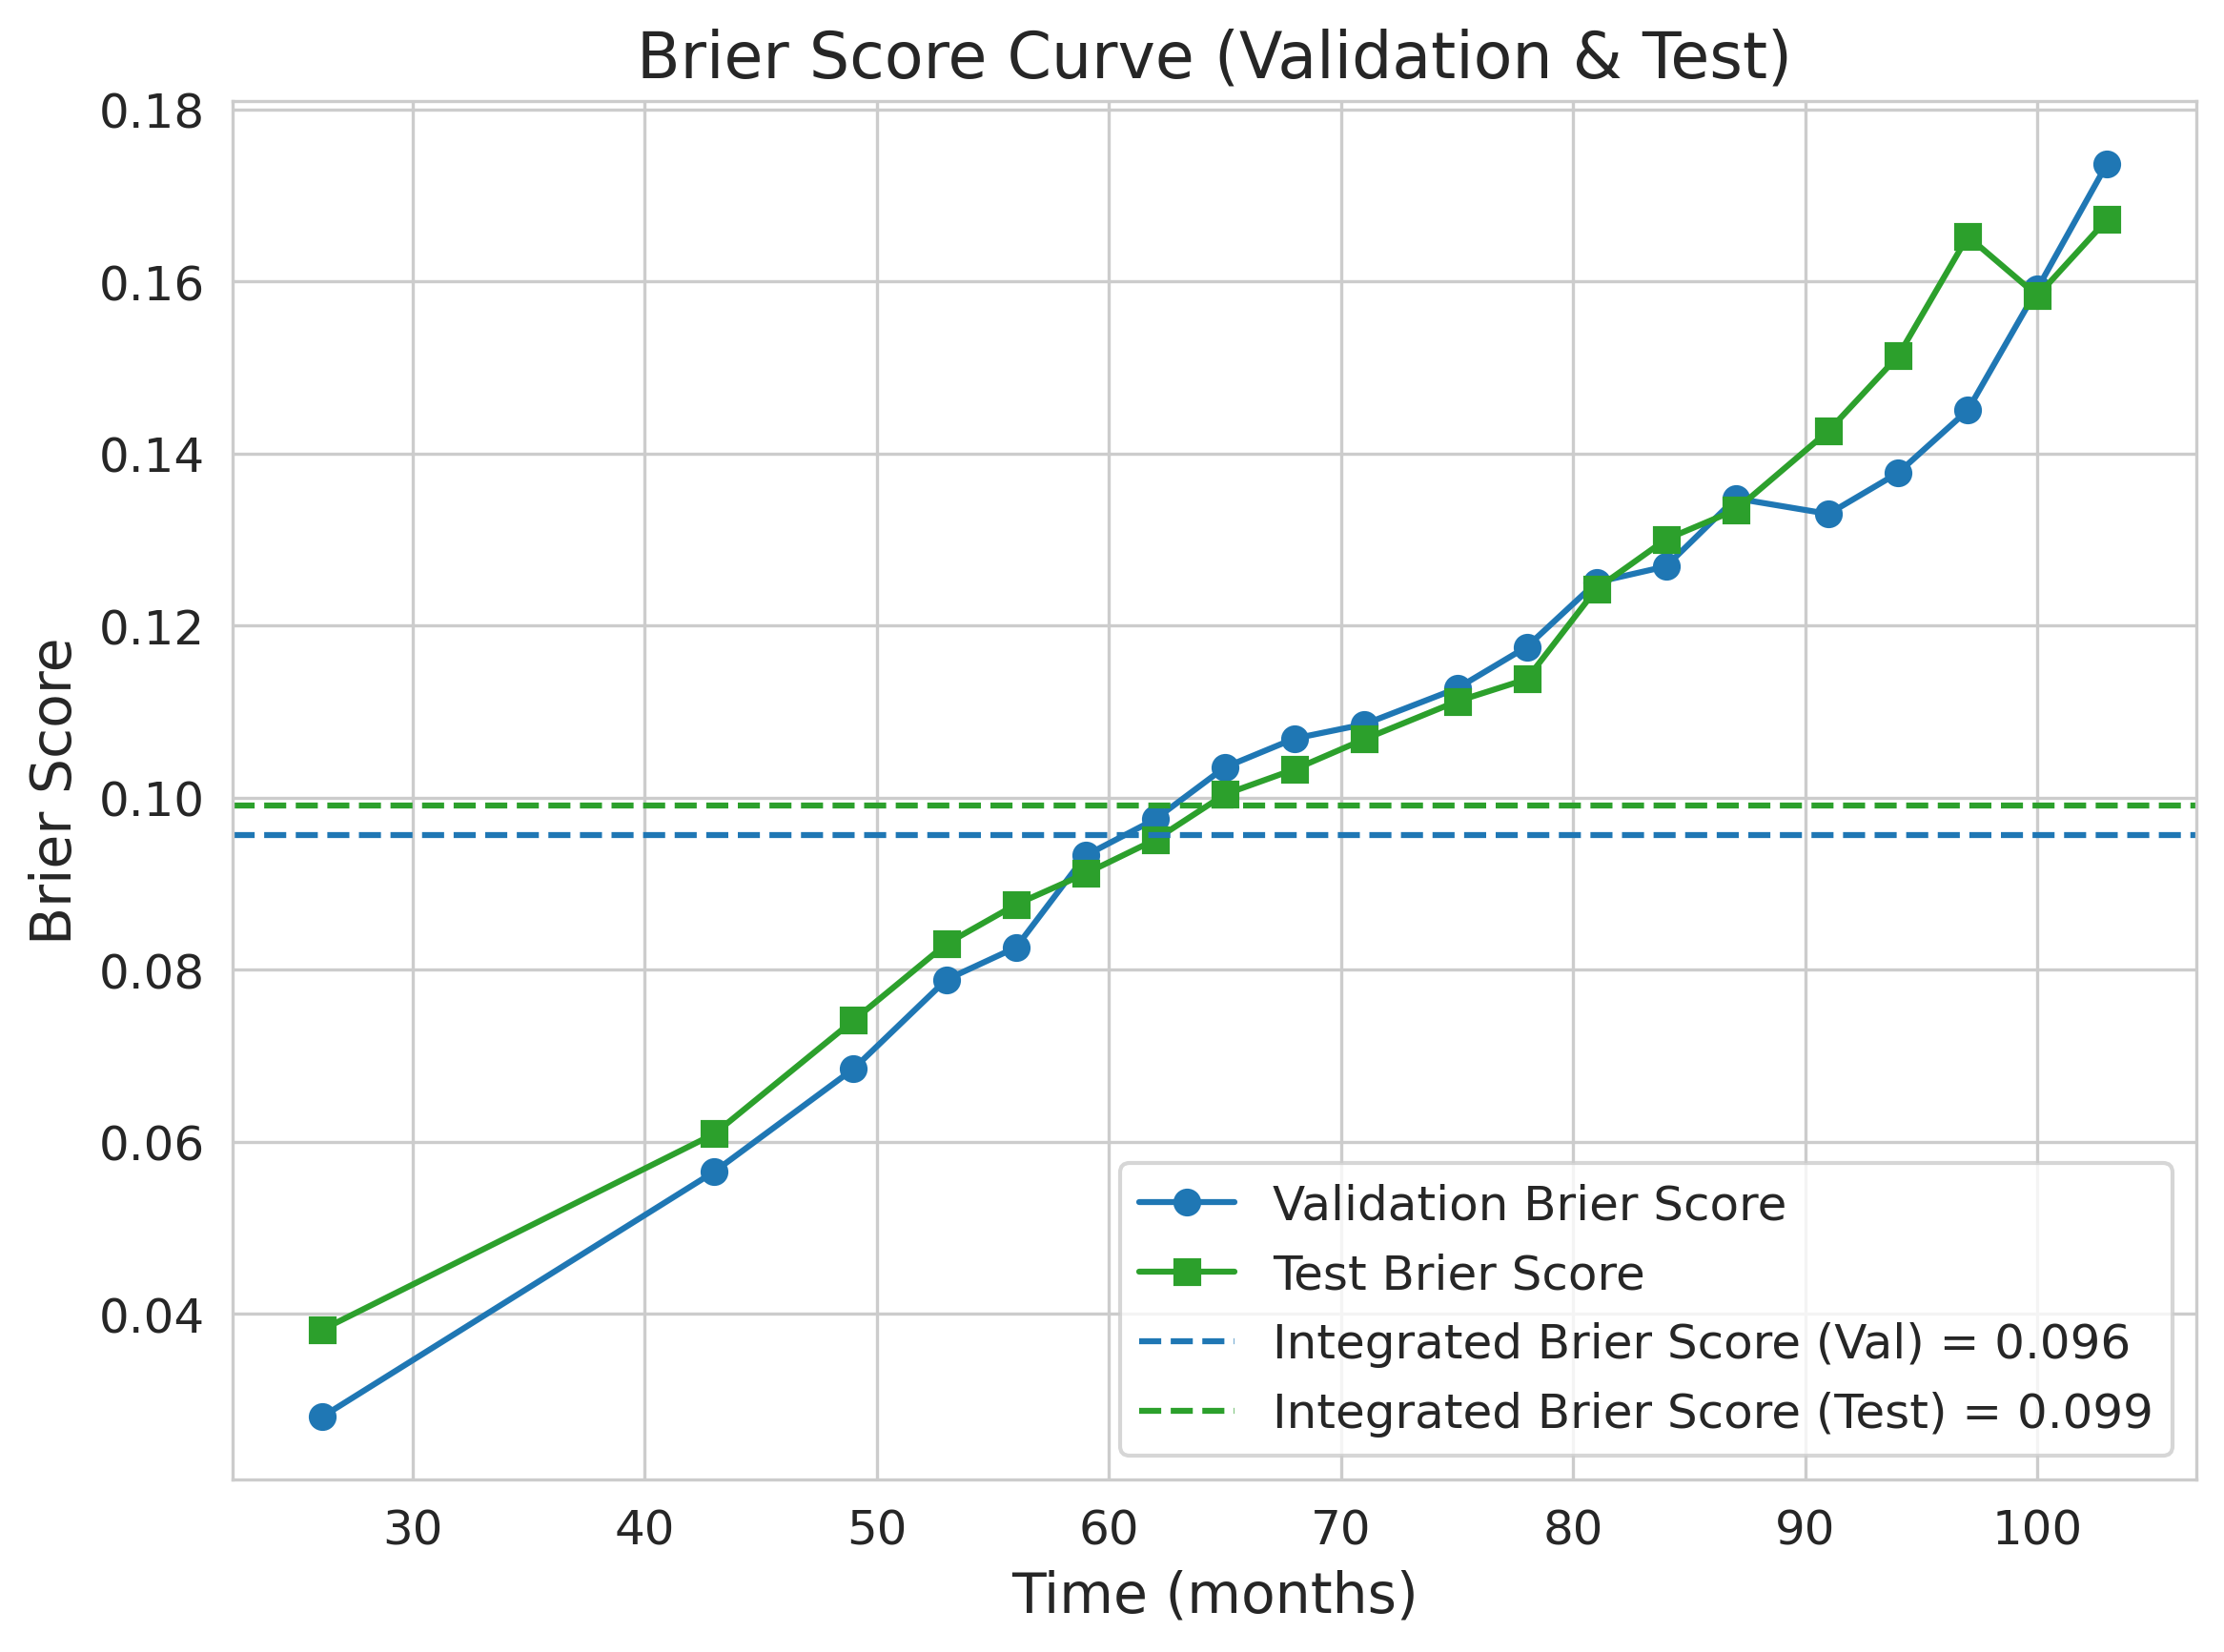

In [26]:

# Use a clean, journal-like style
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300  # High resolution
})

# === 1️ Time-dependent AUC curves (Journal ready) ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(unique_times, auc_vals, marker='o', linestyle='-', color='#1f77b4', label='Validation AUC')
ax.plot(unique_times, aucs_test, marker='s', linestyle='-', color='#ff7f0e', label='Test AUC')

ax.axhline(y=mean_auc_val, color='#1f77b4', linestyle='--', label=f'Mean Val AUC = {mean_auc_val:.3f}')
ax.axhline(y=mean_auc_test, color='#ff7f0e', linestyle='--', label=f'Mean Test AUC = {mean_auc_test:.3f}')

ax.set_xlabel("Time (months)")
ax.set_ylabel("Time-dependent AUC")
ax.set_title("Time-dependent AUC Curves (Validation & Test)")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("Time_dependent_AUC.png", dpi=300, bbox_inches='tight')
plt.show()

# === 2️ Combined Brier Score Curve (Journal ready) ===

val_brier, val_brier_scores = brier_score(y_train, y_val, val_surv_probs, unique_times)
test_brier, test_brier_scores = brier_score(y_train_val, y_test, test_surv_probs, unique_times)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(unique_times, val_brier_scores, marker='o', linestyle='-', color='#1f77b4', label='Validation Brier Score')
ax.plot(unique_times, test_brier_scores, marker='s', linestyle='-', color='#2ca02c', label='Test Brier Score')

ax.axhline(y=ibs_val, color='#1f77b4', linestyle='--', label=f'Integrated Brier Score (Val) = {ibs_val:.3f}')
ax.axhline(y=ibs_test, color='#2ca02c', linestyle='--', label=f'Integrated Brier Score (Test) = {ibs_test:.3f}')

ax.set_xlabel("Time (months)")
ax.set_ylabel("Brier Score")
ax.set_title("Brier Score Curve (Validation & Test)")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("Brier_Score_Curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV

# Note: sksurv models do not directly support sklearn's GridSearchCV
# You can implement manual tuning or use other packages like sksurv's own CV.

# Simple manual grid search example
param_grid = {
    "n_estimators": [100, 200],
    "min_samples_leaf": [10, 15, 20]
}

best_cindex = 0
best_params = {}

for n_est in param_grid["n_estimators"]:
    for min_leaf in param_grid["min_samples_leaf"]:
        model = RandomSurvivalForest(n_estimators=n_est, min_samples_leaf=min_leaf, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cindex = concordance_index_censored(y_val["event"], y_val["time"], preds)[0]
        print(f"n_estimators={n_est}, min_samples_leaf={min_leaf} --> C-index: {cindex:.4f}")
        if cindex > best_cindex:
            best_cindex = cindex
            best_params = {"n_estimators": n_est, "min_samples_leaf": min_leaf}

print(f"Best params: {best_params} with C-index: {best_cindex:.4f}")


n_estimators=100, min_samples_leaf=10 --> C-index: 0.7541
n_estimators=100, min_samples_leaf=15 --> C-index: 0.7565
n_estimators=100, min_samples_leaf=20 --> C-index: 0.7588
n_estimators=200, min_samples_leaf=10 --> C-index: 0.7532
n_estimators=200, min_samples_leaf=15 --> C-index: 0.7545
n_estimators=200, min_samples_leaf=20 --> C-index: 0.7572
Best params: {'n_estimators': 100, 'min_samples_leaf': 20} with C-index: 0.7588


In [32]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import GridSearchCV, KFold

# === 1) Define RSF ===
rsf = RandomSurvivalForest(
    n_jobs=-1,
    random_state=42
)

# === 2) Grid of hyperparameters ===
param_grid = {
    "n_estimators": [100, 200, 300],
    "min_samples_split": [10, 20, 30],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", "log2", 0.5]
}

# === 3) Scoring function ===
def rsf_cindex(model, X, y):
    pred = model.predict(X)
    return concordance_index_censored(y["event"], y["time"], pred)[0]

# === 4) Wrap for sklearn scoring ===
from sklearn.metrics import make_scorer
rsf_scorer = make_scorer(rsf_cindex, greater_is_better=True)

# === 5) K-Fold CV ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# === 6) GridSearchCV ===
grid = GridSearchCV(
    estimator=rsf,
    param_grid=param_grid,
    scoring=rsf_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2
)

# === 7) Fit ===
grid.fit(X_filtered, y_struct)

print("Best Parameters:", grid.best_params_)
print("Best C-index:", grid.best_score_)

# === 8) Use best model ===
best_rsf = grid.best_estimator_

# === 9) Evaluate as usual ===
val_cindex = (y_val["event"], y_val["time"], best_rsf.predict(X_val))[0]
test_cindex = concordance_index_censored(y_test["event"], y_test["time"], best_rsf.predict(X_test))[0]
print(f"Val C-index: {val_cindex:.4f} | Test C-index: {test_cindex:.4f}")
concordance_index_censored

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best C-index: nan
Val C-index: 0.8809 | Test C-index: 0.8776


In [33]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.0 MB/s eta 0:00:00


In [34]:
import optuna
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold

# === 1) K-Fold ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# === 2) Objective function ===
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 400, step=50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 40)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5])

    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )

    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_filtered)):
        X_train, X_val = X_filtered.iloc[train_idx], X_filtered.iloc[val_idx]
        y_train, y_val = y_struct[train_idx], y_struct[val_idx]

        rsf.fit(X_train, y_train)
        pred = rsf.predict(X_val)
        cindex = concordance_index_censored(y_val["event"], y_val["time"], pred)[0]
        fold_scores.append(cindex)
        print(f"Trial {trial.number} - Fold {fold+1} C-index: {cindex:.4f}")

    return sum(fold_scores) / len(fold_scores)

# === 3) Run study ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# === 4) Best params ===
print("Best Params:", study.best_params)
print("Best CV C-index:", study.best_value)

# === 5) Final model with best params ===
best_rsf = RandomSurvivalForest(
    **study.best_params,
    n_jobs=-1,
    random_state=42
)
best_rsf.fit(X_train, y_train)

val_cindex = concordance_index_censored(y_val["event"], y_val["time"], best_rsf.predict(X_val))[0]
test_cindex = concordance_index_censored(y_test["event"], y_test["time"], best_rsf.predict(X_test))[0]
print(f"Val C-index: {val_cindex:.4f} | Test C-index: {test_cindex:.4f}")


[I 2025-06-14 07:59:56,417] A new study created in memory with name: no-name-5255f1d8-513a-4524-86dc-3709479a6d17


Trial 0 - Fold 1 C-index: 0.7128
Trial 0 - Fold 2 C-index: 0.7146
Trial 0 - Fold 3 C-index: 0.7457
Trial 0 - Fold 4 C-index: 0.7214


[I 2025-06-14 08:00:29,280] Trial 0 finished with value: 0.7180334316686301 and parameters: {'n_estimators': 200, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7180334316686301.


Trial 0 - Fold 5 C-index: 0.6956
Trial 1 - Fold 1 C-index: 0.7154
Trial 1 - Fold 2 C-index: 0.7157
Trial 1 - Fold 3 C-index: 0.7534
Trial 1 - Fold 4 C-index: 0.7260


[I 2025-06-14 08:00:50,406] Trial 1 finished with value: 0.7214999504309396 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': 0.5}. Best is trial 1 with value: 0.7214999504309396.


Trial 1 - Fold 5 C-index: 0.6971
Trial 2 - Fold 1 C-index: 0.7165
Trial 2 - Fold 2 C-index: 0.7159
Trial 2 - Fold 3 C-index: 0.7534
Trial 2 - Fold 4 C-index: 0.7292


[I 2025-06-14 08:01:07,373] Trial 2 finished with value: 0.7233086615704335 and parameters: {'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 23, 'max_features': 0.5}. Best is trial 2 with value: 0.7233086615704335.


Trial 2 - Fold 5 C-index: 0.7014
Trial 3 - Fold 1 C-index: 0.7202
Trial 3 - Fold 2 C-index: 0.7225
Trial 3 - Fold 3 C-index: 0.7556
Trial 3 - Fold 4 C-index: 0.7338


[I 2025-06-14 08:01:17,468] Trial 3 finished with value: 0.7287135463750125 and parameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7287135463750125.


Trial 3 - Fold 5 C-index: 0.7115
Trial 4 - Fold 1 C-index: 0.7181
Trial 4 - Fold 2 C-index: 0.7173
Trial 4 - Fold 3 C-index: 0.7538
Trial 4 - Fold 4 C-index: 0.7283


[I 2025-06-14 08:01:24,515] Trial 4 finished with value: 0.7244792652001315 and parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7287135463750125.


Trial 4 - Fold 5 C-index: 0.7048
Trial 5 - Fold 1 C-index: 0.7190
Trial 5 - Fold 2 C-index: 0.7197
Trial 5 - Fold 3 C-index: 0.7570
Trial 5 - Fold 4 C-index: 0.7389


[I 2025-06-14 08:01:31,312] Trial 5 finished with value: 0.7293166825450245 and parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7293166825450245.


Trial 5 - Fold 5 C-index: 0.7119
Trial 6 - Fold 1 C-index: 0.7199
Trial 6 - Fold 2 C-index: 0.7221
Trial 6 - Fold 3 C-index: 0.7509
Trial 6 - Fold 4 C-index: 0.7365


[I 2025-06-14 08:01:34,617] Trial 6 finished with value: 0.7284134301088876 and parameters: {'n_estimators': 100, 'min_samples_split': 29, 'min_samples_leaf': 30, 'max_features': 'log2'}. Best is trial 5 with value: 0.7293166825450245.


Trial 6 - Fold 5 C-index: 0.7127
Trial 7 - Fold 1 C-index: 0.7105
Trial 7 - Fold 2 C-index: 0.7168
Trial 7 - Fold 3 C-index: 0.7539
Trial 7 - Fold 4 C-index: 0.7258


[I 2025-06-14 08:01:43,283] Trial 7 finished with value: 0.7210983418599983 and parameters: {'n_estimators': 150, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 0.5}. Best is trial 5 with value: 0.7293166825450245.


Trial 7 - Fold 5 C-index: 0.6985
Trial 8 - Fold 1 C-index: 0.7218
Trial 8 - Fold 2 C-index: 0.7173
Trial 8 - Fold 3 C-index: 0.7469
Trial 8 - Fold 4 C-index: 0.7279


[I 2025-06-14 08:01:47,995] Trial 8 finished with value: 0.7231099042434089 and parameters: {'n_estimators': 100, 'min_samples_split': 29, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 5 with value: 0.7293166825450245.


Trial 8 - Fold 5 C-index: 0.7016
Trial 9 - Fold 1 C-index: 0.7186
Trial 9 - Fold 2 C-index: 0.7227
Trial 9 - Fold 3 C-index: 0.7547
Trial 9 - Fold 4 C-index: 0.7362


[I 2025-06-14 08:02:01,628] Trial 9 finished with value: 0.7292912241158598 and parameters: {'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 27, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7293166825450245.


Trial 9 - Fold 5 C-index: 0.7142
Trial 10 - Fold 1 C-index: 0.7192
Trial 10 - Fold 2 C-index: 0.7199
Trial 10 - Fold 3 C-index: 0.7538
Trial 10 - Fold 4 C-index: 0.7329


[I 2025-06-14 08:02:18,792] Trial 10 finished with value: 0.7264229445755668 and parameters: {'n_estimators': 400, 'min_samples_split': 40, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7293166825450245.


Trial 10 - Fold 5 C-index: 0.7062
Trial 11 - Fold 1 C-index: 0.7176
Trial 11 - Fold 2 C-index: 0.7229
Trial 11 - Fold 3 C-index: 0.7541
Trial 11 - Fold 4 C-index: 0.7350


[I 2025-06-14 08:02:28,149] Trial 11 finished with value: 0.7291177842036363 and parameters: {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 29, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.7293166825450245.


Trial 11 - Fold 5 C-index: 0.7159
Trial 12 - Fold 1 C-index: 0.7202
Trial 12 - Fold 2 C-index: 0.7230
Trial 12 - Fold 3 C-index: 0.7564
Trial 12 - Fold 4 C-index: 0.7374


[I 2025-06-14 08:02:43,263] Trial 12 finished with value: 0.7295061517438848 and parameters: {'n_estimators': 400, 'min_samples_split': 14, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.7295061517438848.


Trial 12 - Fold 5 C-index: 0.7104
Trial 13 - Fold 1 C-index: 0.7193
Trial 13 - Fold 2 C-index: 0.7228
Trial 13 - Fold 3 C-index: 0.7557
Trial 13 - Fold 4 C-index: 0.7371


[I 2025-06-14 08:02:51,939] Trial 13 finished with value: 0.7297339153307859 and parameters: {'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7297339153307859.


Trial 13 - Fold 5 C-index: 0.7137
Trial 14 - Fold 1 C-index: 0.7189
Trial 14 - Fold 2 C-index: 0.7228
Trial 14 - Fold 3 C-index: 0.7550
Trial 14 - Fold 4 C-index: 0.7365


[I 2025-06-14 08:03:06,586] Trial 14 finished with value: 0.7290024621676415 and parameters: {'n_estimators': 400, 'min_samples_split': 16, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7297339153307859.


Trial 14 - Fold 5 C-index: 0.7118
Trial 15 - Fold 1 C-index: 0.7179
Trial 15 - Fold 2 C-index: 0.7215
Trial 15 - Fold 3 C-index: 0.7551
Trial 15 - Fold 4 C-index: 0.7337


[I 2025-06-14 08:03:17,272] Trial 15 finished with value: 0.72773199683737 and parameters: {'n_estimators': 250, 'min_samples_split': 25, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7297339153307859.


Trial 15 - Fold 5 C-index: 0.7105
Trial 16 - Fold 1 C-index: 0.7194
Trial 16 - Fold 2 C-index: 0.7225
Trial 16 - Fold 3 C-index: 0.7561
Trial 16 - Fold 4 C-index: 0.7381


[I 2025-06-14 08:03:28,614] Trial 16 finished with value: 0.7295118243845814 and parameters: {'n_estimators': 300, 'min_samples_split': 14, 'min_samples_leaf': 25, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7297339153307859.


Trial 16 - Fold 5 C-index: 0.7114
Trial 17 - Fold 1 C-index: 0.7171
Trial 17 - Fold 2 C-index: 0.7199
Trial 17 - Fold 3 C-index: 0.7544
Trial 17 - Fold 4 C-index: 0.7330


[I 2025-06-14 08:03:40,949] Trial 17 finished with value: 0.7264031102104962 and parameters: {'n_estimators': 300, 'min_samples_split': 23, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7297339153307859.


Trial 17 - Fold 5 C-index: 0.7077
Trial 18 - Fold 1 C-index: 0.7144
Trial 18 - Fold 2 C-index: 0.7150
Trial 18 - Fold 3 C-index: 0.7513
Trial 18 - Fold 4 C-index: 0.7253


[I 2025-06-14 08:03:52,275] Trial 18 finished with value: 0.7198093479362166 and parameters: {'n_estimators': 200, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 0.5}. Best is trial 13 with value: 0.7297339153307859.


Trial 18 - Fold 5 C-index: 0.6931
Trial 19 - Fold 1 C-index: 0.7177
Trial 19 - Fold 2 C-index: 0.7216
Trial 19 - Fold 3 C-index: 0.7541
Trial 19 - Fold 4 C-index: 0.7362


[I 2025-06-14 08:04:00,422] Trial 19 finished with value: 0.7288022869780961 and parameters: {'n_estimators': 250, 'min_samples_split': 20, 'min_samples_leaf': 27, 'max_features': 'log2'}. Best is trial 13 with value: 0.7297339153307859.


Trial 19 - Fold 5 C-index: 0.7145
Best Params: {'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 24, 'max_features': 'sqrt'}
Best CV C-index: 0.7297339153307859
Val C-index: 0.7579 | Test C-index: 0.7178


In [35]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer

# === 1) Model ===
rsf = RandomSurvivalForest(
    n_jobs=-1,
    random_state=42
)

# === 2) Parameter space ===
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "min_samples_split": [2, 10, 20, 30],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.5]
}

# === 3) Scorer ===
def rsf_cindex(model, X, y):
    pred = model.predict(X)
    return concordance_index_censored(y["event"], y["time"], pred)[0]

rsf_scorer = make_scorer(rsf_cindex, greater_is_better=True)

# === 4) K-Fold ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# === 5) RandomizedSearch ===
random_search = RandomizedSearchCV(
    estimator=rsf,
    param_distributions=param_dist,
    n_iter=10,  # number of random combos to try
    scoring=rsf_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === 6) Run ===
random_search.fit(X_filtered, y_struct)

# === 7) Best ===
print("Best Params:", random_search.best_params_)
print("Best CV C-index:", random_search.best_score_)

# === 8) All folds for all trials ===
cv_results = random_search.cv_results_
for mean, std, params in zip(
    cv_results["mean_test_score"],
    cv_results["std_test_score"],
    cv_results["params"]
):
    print(f"Mean C-index: {mean:.4f} ± {std:.4f} | Params: {params}")

# === 9) Evaluate on Val & Test ===
best_rsf = random_search.best_estimator_

val_cindex = concordance_index_censored(y_val["event"], y_val["time"], best_rsf.predict(X_val))[0]
test_cindex = concordance_index_censored(y_test["event"], y_test["time"], best_rsf.predict(X_test))[0]
print(f"Val C-index: {val_cindex:.4f} | Test C-index: {test_cindex:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2'}
Best CV C-index: nan
Mean C-index: nan ± nan | Params: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2'}
Mean C-index: nan ± nan | Params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt'}
Mean C-index: nan ± nan | Params: {'n_estimators': 300, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_features': 'log2'}
Mean C-index: nan ± nan | Params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean C-index: nan ± nan | Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}
Mean C-index: nan ± nan | Params: {'n_estimators': 400, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2'}
Mean C-index: nan ± nan | Params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 20, '

In [46]:
import numpy as np
import pandas as pd

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import (
    RandomSurvivalForest,
    GradientBoostingSurvivalAnalysis,
    ComponentwiseGradientBoostingSurvivalAnalysis,
)
from sksurv.metrics import (
    concordance_index_censored,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score,
)
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")


# === 2) Define time grid ===
median_time = np.percentile(y_struct["time"], 50)
unique_times = np.percentile(y_struct["time"], np.linspace(5, 95, 20))
idx_median = np.argmin(np.abs(unique_times - median_time))

# === 3) Define models ===
models = {
    "CoxPH": CoxPHSurvivalAnalysis(),
    "Coxnet": CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=[0.01], fit_baseline_model=True),
    "RSF": RandomSurvivalForest(
        n_estimators=100, min_samples_split=20, min_samples_leaf=15,
        max_features="sqrt", n_jobs=-1, random_state=42),
    "GBSA": GradientBoostingSurvivalAnalysis(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "CGBSA": ComponentwiseGradientBoostingSurvivalAnalysis(
        n_estimators=100, learning_rate=0.1, random_state=42),
}


# === 4) Store results ===
overall_results = []
cv_results_all = {}

# === 5) Loop ===
for model_name, model in models.items():
    print(f"=== {model_name} ===")

    # Fit
    model.fit(X_train, y_train)

    # Predict
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # C-index
    val_cindex = concordance_index_censored(y_val["event"], y_val["time"], val_pred)[0]
    test_cindex = concordance_index_censored(y_test["event"], y_test["time"], test_pred)[0]

    # Survival probs
    val_surv = np.vstack([fn(unique_times) for fn in model.predict_survival_function(X_val)])
    test_surv = np.vstack([fn(unique_times) for fn in model.predict_survival_function(X_test)])

    # IBS
    ibs_val = integrated_brier_score(y_train, y_val, val_surv, unique_times)
    ibs_test = integrated_brier_score(y_train_val, y_test, test_surv, unique_times)

    # Brier@median
    val_brier_median = brier_score(
        y_train, y_val, val_surv[:, idx_median].reshape(-1, 1), np.array([median_time])
    )[1][0]
    test_brier_median = brier_score(
        y_train_val, y_test, test_surv[:, idx_median].reshape(-1, 1), np.array([median_time])
    )[1][0]

    # Time-dependent AUC
    _, mean_auc_val = cumulative_dynamic_auc(y_train, y_val, val_pred, unique_times)
    _, mean_auc_test = cumulative_dynamic_auc(y_train_val, y_test, test_pred, unique_times)

    # Store to list
    overall_results.append({
        "Model": model_name,
        "Val C-index": val_cindex,
        "Test C-index": test_cindex,
        "Val IBS": ibs_val,
        "Test IBS": ibs_test,
        "Val Brier@Median": val_brier_median,
        "Test Brier@Median": test_brier_median,
        "Val Mean AUC": mean_auc_val,
        "Test Mean AUC": mean_auc_test,
    })

    # 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_cindex, cv_ibs, cv_brier_median, cv_mean_auc = [], [], [], []

    for fold, (tr_idx, te_idx) in enumerate(kf.split(X_filtered)):
        X_tr, X_te = X_filtered.iloc[tr_idx], X_filtered.iloc[te_idx]
        y_tr, y_te = y_struct[tr_idx], y_struct[te_idx]

        model_cv = models[model_name]
        model_cv.fit(X_tr, y_tr)

        pred_cv = model_cv.predict(X_te)
        cindex = concordance_index_censored(y_te["event"], y_te["time"], pred_cv)[0]

        surv_cv = np.vstack([fn(unique_times) for fn in model_cv.predict_survival_function(X_te)])
        ibs = integrated_brier_score(y_tr, y_te, surv_cv, unique_times)
        brier_median = brier_score(
            y_tr, y_te, surv_cv[:, idx_median].reshape(-1, 1), np.array([median_time])
        )[1][0]
        _, mean_auc = cumulative_dynamic_auc(y_tr, y_te, pred_cv, unique_times)

        cv_cindex.append(cindex)
        cv_ibs.append(ibs)
        cv_brier_median.append(brier_median)
        cv_mean_auc.append(mean_auc)

    # Save CV DataFrame
    df_cv = pd.DataFrame({
        "Fold": np.arange(1, 6),
        "C-index": cv_cindex,
        "IBS": cv_ibs,
        "Brier@Median": cv_brier_median,
        "Mean AUC": cv_mean_auc,
    })
    cv_results_all[model_name] = df_cv

print("\n=== Overall Validation & Test Results ===")
df_overall = pd.DataFrame(overall_results)
display(df_overall)


print("\n=== 5-Fold Cross-Validation Results for Each Model ===")
for model_name, df_cv in cv_results_all.items():
    print(f"\n{model_name} CV Results:")
    display(df_cv)
    print("Mean ± Std per metric:")
    for col in ["C-index", "IBS", "Brier@Median", "Mean AUC"]:
        mean = df_cv[col].mean()
        std = df_cv[col].std()
        print(f"{col}: {mean:.4f} ± {std:.4f}")

=== CoxPH ===
=== Coxnet ===
=== RSF ===
=== GBSA ===
=== CGBSA ===

=== 📊 Overall Validation & Test Results ===


,Model,Val C-index,Test C-index,Val IBS,Test IBS,Val Brier@Median,Test Brier@Median,Val Mean AUC,Test Mean AUC
0,CoxPH,0.752068,0.735344,0.095342,0.096647,0.109195,0.106211,0.760390,0.748700
1,Coxnet,0.756960,0.721120,0.094108,0.098364,0.107557,0.107357,0.764327,0.732677
2,RSF,0.756457,0.720350,0.095715,0.099132,0.109274,0.108473,0.764385,0.734271
3,GBSA,0.736451,0.713277,0.098573,0.099967,0.112303,0.109866,0.743188,0.724107
4,CGBSA,0.702867,0.648424,0.099105,0.105412,0.115220,0.114621,0.710398,0.654451



=== 📊 5-Fold Cross-Validation Results for Each Model ===

CoxPH CV Results:


,Fold,C-index,IBS,Brier@Median,Mean AUC
0,1,0.725152,0.105974,0.119093,0.751624
1,2,0.732683,0.098579,0.113370,0.740158
2,3,0.770180,0.080174,0.087167,0.798289
3,4,0.753327,0.097415,0.110548,0.777008
4,5,0.726982,0.093932,0.106111,0.745562


Mean ± Std per metric:
C-index: 0.7417 ± 0.0195
IBS: 0.0952 ± 0.0095
Brier@Median: 0.1073 ± 0.0122
Mean AUC: 0.7625 ± 0.0245

Coxnet CV Results:


,Fold,C-index,IBS,Brier@Median,Mean AUC
0,1,0.714562,0.107464,0.120866,0.740325
1,2,0.734388,0.098074,0.112768,0.742563
2,3,0.762632,0.082108,0.089549,0.788188
3,4,0.743275,0.099318,0.112056,0.764845
4,5,0.716784,0.093932,0.106166,0.735703


Mean ± Std per metric:
C-index: 0.7343 ± 0.0199
IBS: 0.0962 ± 0.0093
Brier@Median: 0.1083 ± 0.0117
Mean AUC: 0.7543 ± 0.0220

RSF CV Results:


,Fold,C-index,IBS,Brier@Median,Mean AUC
0,1,0.720105,0.107436,0.121766,0.742433
1,2,0.717969,0.099735,0.115441,0.727705
2,3,0.751624,0.083893,0.091552,0.774102
3,4,0.732157,0.099455,0.112797,0.755909
4,5,0.710083,0.093935,0.106330,0.727903


Mean ± Std per metric:
C-index: 0.7264 ± 0.0162
IBS: 0.0969 ± 0.0087
Brier@Median: 0.1096 ± 0.0115
Mean AUC: 0.7456 ± 0.0198

GBSA CV Results:


,Fold,C-index,IBS,Brier@Median,Mean AUC
0,1,0.720290,0.108143,0.122412,0.742879
1,2,0.719324,0.101099,0.117212,0.731274
2,3,0.743654,0.083067,0.089413,0.764169
3,4,0.730892,0.101317,0.114760,0.753212
4,5,0.714079,0.093430,0.106106,0.730503


Mean ± Std per metric:
C-index: 0.7256 ± 0.0118
IBS: 0.0974 ± 0.0096
Brier@Median: 0.1100 ± 0.0129
Mean AUC: 0.7444 ± 0.0145

CGBSA CV Results:


,Fold,C-index,IBS,Brier@Median,Mean AUC
0,1,0.669519,0.114036,0.129225,0.688772
1,2,0.702526,0.103079,0.120766,0.708039
2,3,0.654012,0.089732,0.098330,0.675772
3,4,0.685098,0.105417,0.116615,0.699389
4,5,0.683772,0.097608,0.111236,0.698426


Mean ± Std per metric:
C-index: 0.6790 ± 0.0182
IBS: 0.1020 ± 0.0090
Brier@Median: 0.1152 ± 0.0115
Mean AUC: 0.6941 ± 0.0123
